In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional,Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import tensorflow as tf
import keras

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:

# Display the version of each library
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", StandardScaler().fit_transform([[0]])[0, 0])  # sklearn version
print("tensorflow version:", tf.__version__)  # assuming 'tf' is your TensorFlow import
print("keras version:", keras.__version__)

pandas version: 2.1.4
matplotlib version: 3.7.4
seaborn version: 0.12.2
numpy version: 1.24.3
scikit-learn version: 0.0
tensorflow version: 2.13.0
keras version: 2.13.1


In [6]:
warnings.filterwarnings(action="ignore")

In [80]:
df = pd.read_excel("/kaggle/input/algo-banknifty/Test Data Set  Requirements.xlsx",sheet_name="Data")

In [8]:
feature_data = df[df.strike == 1]
feature_data["spot_closing"] = df[df.strike == 0].close.to_list()
# feature_data["diff_closing_opening"] = feature_data.close.shift() - feature_data.open
feature_data["oi_change"] = np.log(feature_data.oi).pct_change()
feature_data["log_Target_price"] = np.log(feature_data.close)
feature_data["log_Target_return"] = feature_data.log_Target_price.pct_change()
feature_data["Target"] = feature_data["log_Target_return"].apply(lambda x: 0 if x > 0 else 1)
feature_data.fillna(0,inplace=True)
feature_data.drop(columns=["type","strike"],inplace=True)
feature_data.head()

,Unnamed: 0,date,open,high,low,close,volume,oi,spot_closing,oi_change,log_Target_price,log_Target_return,Target
375,0,2023-02-02 09:15:00,40289.00,40420.7,40217.95,40276.75,156150,2377775,40058.25,0.000000,10.603530,0.000000,1
376,1,2023-02-02 09:16:00,40251.15,40265.9,40074.40,40123.70,90750,2377775,39906.75,0.000000,10.599722,-0.000359,1
377,2,2023-02-02 09:17:00,40125.00,40126.1,40007.80,40061.30,68250,2409850,39812.45,0.000913,10.598166,-0.000147,1
378,3,2023-02-02 09:18:00,40040.60,40105.8,40016.95,40094.25,72675,2409850,39852.25,0.000000,10.598988,0.000078,0
379,4,2023-02-02 09:19:00,40079.75,40090.9,40024.65,40071.75,58550,2409850,39834.70,0.000000,10.598427,-0.000053,1


In [9]:
# adding option data and strike price as feature 
def option_value(data, refer, _type_, shift,which):
    ls = []
    df = refer
    if which == "price":
        which = "close"
    for i in data.date:
        element = df[(df.date == i) & (df["type"]==_type_) &
                (df["strike"] == int(data.loc[data[data.date == i].index,"strike_price"].values[0] + shift))][f"{which}"].values[0]
        ls.append(element)
    return ls

# adding ATM value and oi of CE and PE at corresponding time
feature_data["strike_price"] = round(feature_data["spot_closing"]/100)*100
feature_data["atm_ce_price"] = option_value(feature_data, df, "CE", shift=0,which="price") 
feature_data["atm_pe_price"] = option_value(feature_data, df, "PE", shift=0,which="price") 
feature_data["atm_ce_oi"] = option_value(feature_data, df, "CE", shift=0,which="oi") 
feature_data["atm_pe_oi"] = option_value(feature_data, df, "PE", shift=0,which="oi")

# adding three consecutive ITM value and oi of CE and PE at corresponding time
feature_data["1itm_ce_price"] = option_value(feature_data,df,"CE",shift=(-100),which="price")
feature_data["1itm_pe_price"] = option_value(feature_data,df,"PE",shift=(100),which="price")
feature_data["1itm_ce_oi"] = option_value(feature_data,df,"CE",shift=(-100),which="oi")
feature_data["1itm_pe_oi"] = option_value(feature_data,df,"PE",shift=(100),which="oi") 
feature_data["2itm_ce_price"] = option_value(feature_data,df,"CE",shift=(-200),which="price") 
feature_data["2itm_pe_price"] = option_value(feature_data,df,"PE",shift=(200),which="price")
feature_data["2itm_ce_oi"] = option_value(feature_data,df,"CE",shift=(-200),which="oi") 
feature_data["2itm_pe_oi"] = option_value(feature_data,df,"PE",shift=(200),which="oi") 
feature_data["3itm_ce_price"] = option_value(feature_data,df,"CE",shift=(-300),which="price") 
feature_data["3itm_pe_price"] = option_value(feature_data,df,"PE",shift=(300),which="price")
feature_data["3itm_ce_oi"] = option_value(feature_data,df,"CE",shift=(-300),which="oi")
feature_data["3itm_pe_oi"] = option_value(feature_data,df,"PE",shift=(300),which="oi") 

# adding three consecutive OTM value and oi of CE and PE at corresponding time
feature_data["1otm_ce_price"] = option_value(feature_data,df,"CE",shift=(100),which="price")
feature_data["1otm_pe_price"] = option_value(feature_data,df,"PE",shift=(-100),which="price")
feature_data["1otm_ce_oi"] = option_value(feature_data,df,"CE",shift=(100),which="oi")
feature_data["1otm_pe_oi"] = option_value(feature_data,df,"PE",shift=(-100),which="oi") 
feature_data["2otm_ce_price"] = option_value(feature_data,df,"CE",shift=(200),which="price") 
feature_data["2otm_pe_price"] = option_value(feature_data,df,"PE",shift=(-200),which="price")
feature_data["2otm_ce_oi"] = option_value(feature_data,df,"CE",shift=(200),which="oi") 
feature_data["2otm_pe_oi"] = option_value(feature_data,df,"PE",shift=(-200),which="oi") 
feature_data["3otm_ce_price"] = option_value(feature_data,df,"CE",shift=(300),which="price") 
feature_data["3otm_pe_price"] = option_value(feature_data,df,"PE",shift=(-300),which="price")
feature_data["3otm_ce_oi"] = option_value(feature_data,df,"CE",shift=(300),which="oi")
feature_data["3otm_pe_oi"] = option_value(feature_data,df,"PE",shift=(-300),which="oi") 

In [10]:
feature_data["consecutive_ce_oi"] = feature_data['atm_ce_oi'] + feature_data['1itm_ce_oi'] + feature_data['2itm_ce_oi'] + feature_data['3itm_ce_oi'] + feature_data['1otm_ce_oi'] +feature_data['1otm_ce_oi'] +feature_data['3otm_ce_oi'] 

feature_data["consecutive_pe_oi"] = feature_data['atm_pe_oi'] + feature_data['1itm_pe_oi'] + feature_data['2itm_pe_oi'] + feature_data['3itm_pe_oi'] + feature_data['1otm_pe_oi'] +feature_data['1otm_pe_oi'] +feature_data['3otm_pe_oi'] 


feature_data["ce_oi_change"] = np.log(feature_data["consecutive_ce_oi"]).pct_change()
feature_data["pe_oi_change"] = np.log(feature_data["consecutive_pe_oi"]).pct_change()

In [11]:
feature_data.columns

Index(['Unnamed: 0', 'date', 'open', 'high', 'low', 'close', 'volume', 'oi',
       'spot_closing', 'oi_change', 'log_Target_price', 'log_Target_return',
       'Target', 'strike_price', 'atm_ce_price', 'atm_pe_price', 'atm_ce_oi',
       'atm_pe_oi', '1itm_ce_price', '1itm_pe_price', '1itm_ce_oi',
       '1itm_pe_oi', '2itm_ce_price', '2itm_pe_price', '2itm_ce_oi',
       '2itm_pe_oi', '3itm_ce_price', '3itm_pe_price', '3itm_ce_oi',
       '3itm_pe_oi', '1otm_ce_price', '1otm_pe_price', '1otm_ce_oi',
       '1otm_pe_oi', '2otm_ce_price', '2otm_pe_price', '2otm_ce_oi',
       '2otm_pe_oi', '3otm_ce_price', '3otm_pe_price', '3otm_ce_oi',
       '3otm_pe_oi', 'consecutive_ce_oi', 'consecutive_pe_oi', 'ce_oi_change',
       'pe_oi_change'],
      dtype='object')

## Data analysis

<Axes: xlabel='date', ylabel='1itm_ce_price'>

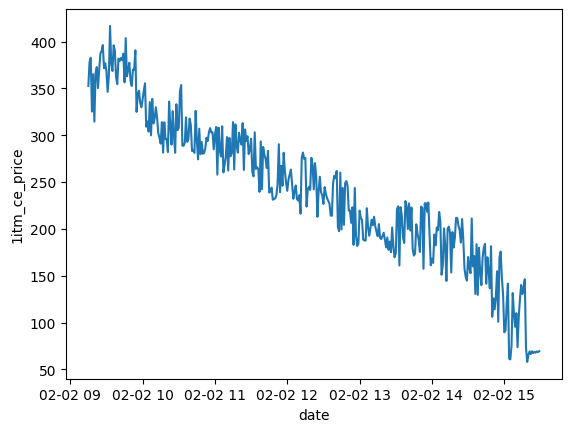

In [12]:
sns.lineplot(x=feature_data.date, y=feature_data["1itm_ce_price"])

In [13]:
data = feature_data[["Target","date", 'open','atm_ce_price','volume', 'oi',
       'spot_closing', 'oi_change',
       'atm_pe_price', 'atm_ce_oi', 'atm_pe_oi', '1itm_ce_price',
       '1itm_pe_price', '1itm_ce_oi', '1itm_pe_oi', '2itm_ce_price',
       '2itm_pe_price', '2itm_ce_oi', '2itm_pe_oi', '3itm_ce_price',
       '3itm_pe_price', '3itm_ce_oi', '3itm_pe_oi', '1otm_ce_price',
       '1otm_pe_price', '1otm_ce_oi', '1otm_pe_oi', '2otm_ce_price',
       '2otm_pe_price', '2otm_ce_oi', '2otm_pe_oi', '3otm_ce_price',
       '3otm_pe_price', '3otm_ce_oi', '3otm_pe_oi', 'consecutive_ce_oi',
       'consecutive_pe_oi', 'ce_oi_change', 'pe_oi_change']]
data = data[(data.date > "2023-02-02 09:29:00") & (data.date < "2023-02-02 14:10:00")]
print(data.shape)
data.head()


(280, 39)


,Target,date,open,atm_ce_price,volume,oi,spot_closing,oi_change,atm_pe_price,atm_ce_oi,...,2otm_ce_oi,2otm_pe_oi,3otm_ce_price,3otm_pe_price,3otm_ce_oi,3otm_pe_oi,consecutive_ce_oi,consecutive_pe_oi,ce_oi_change,pe_oi_change
390,0,2023-02-02 09:30:00,40432.00,311.75,24025,2491300,40281.80,0.000000,325.00,798425,...,1755425,704425,181.70,205.20,663400,3186625,5223150,7468700,-0.012910,0.019902
391,1,2023-02-02 09:31:00,40511.05,292.25,22775,2491300,40250.70,0.000000,343.50,798425,...,1755425,704425,167.85,221.00,663400,3186625,5223150,7468700,0.000000,0.000000
392,1,2023-02-02 09:32:00,40458.30,306.45,41650,2495600,40159.40,0.000117,335.20,769575,...,562250,3186625,179.05,216.00,1755425,1150325,6382550,5484325,0.012960,-0.019514
393,0,2023-02-02 09:33:00,40404.20,348.65,18275,2495600,40231.35,0.000000,282.65,859900,...,630300,3154200,209.25,177.75,1832725,1142600,6947050,5633325,0.005409,0.001727
394,1,2023-02-02 09:34:00,40510.00,317.85,29975,2495600,40186.45,0.000000,311.35,859900,...,630300,3154200,184.60,200.50,1832725,1142600,6947050,5633325,0.000000,0.000000


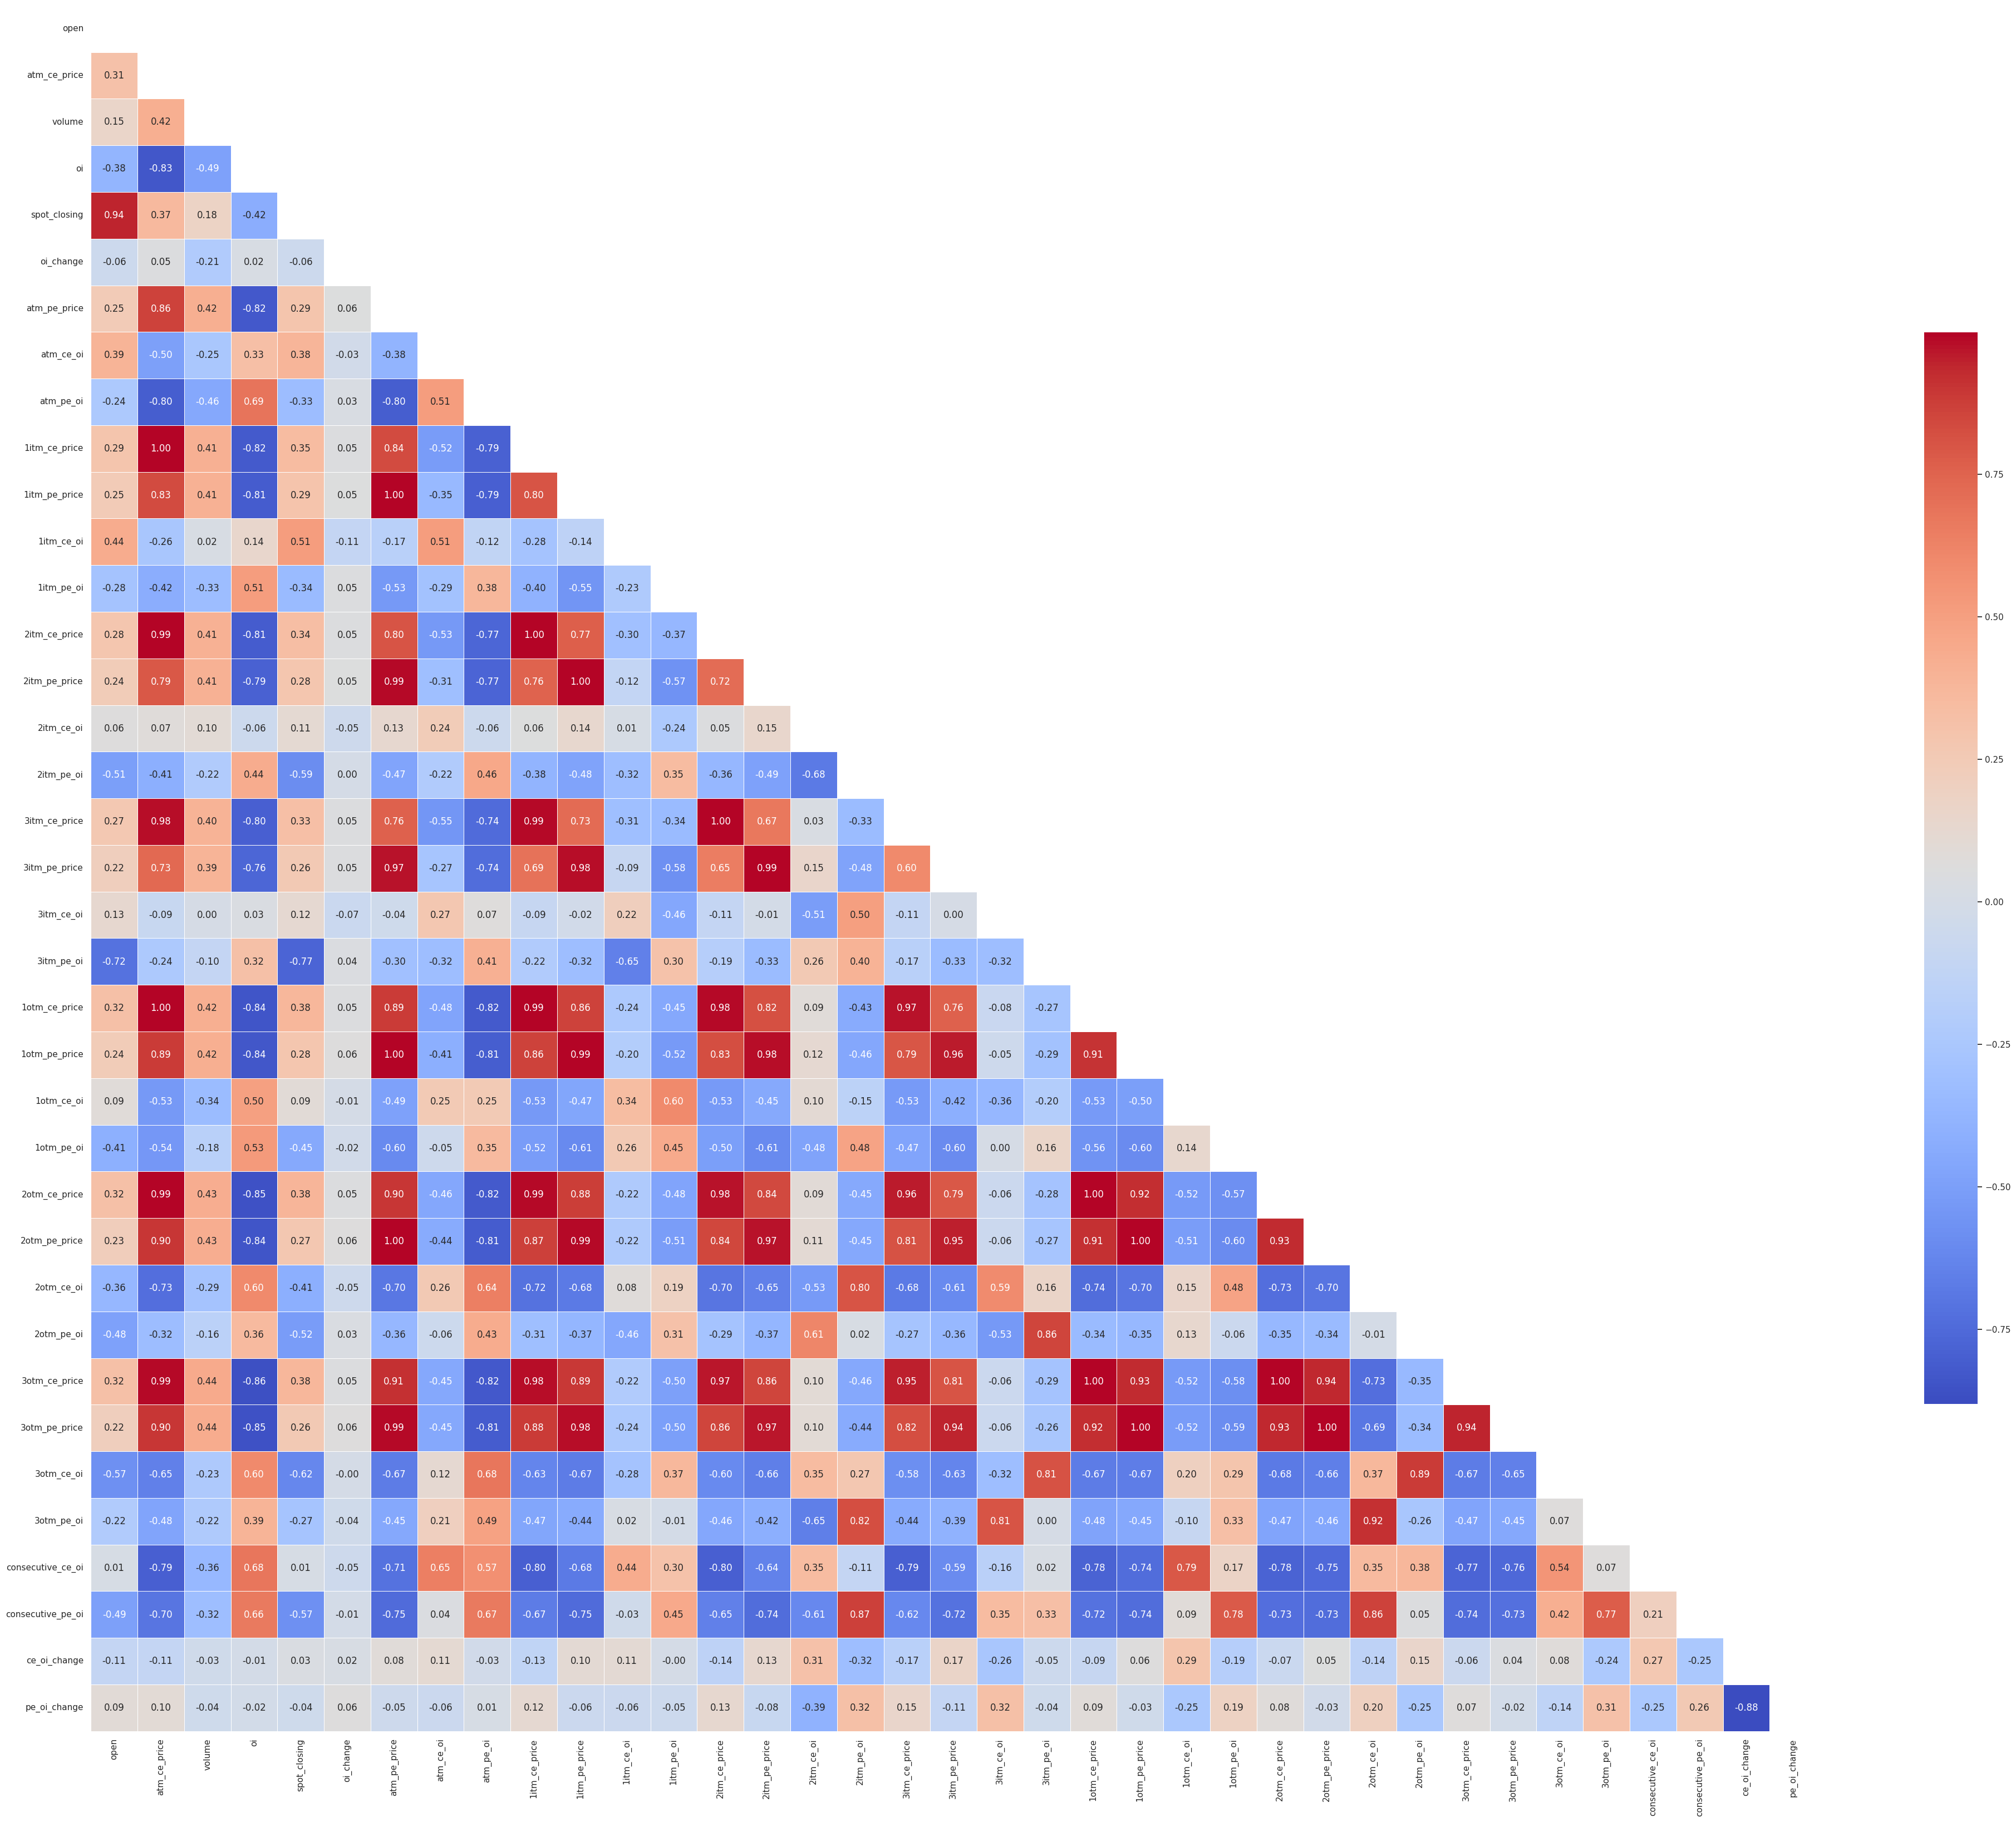

In [14]:
cor = data.drop(columns=["date","Target"])
corr = cor.corr()

# Create a heatmap with annotations
sns.set(style='white')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [15]:
corr_matrix = cor.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
print("No. of Columns to drop",len(to_drop))
to_drop

No. of Columns to drop 12


['1itm_ce_price',
 '1itm_pe_price',
 '2itm_ce_price',
 '2itm_pe_price',
 '3itm_ce_price',
 '3itm_pe_price',
 '1otm_ce_price',
 '1otm_pe_price',
 '2otm_ce_price',
 '2otm_pe_price',
 '3otm_ce_price',
 '3otm_pe_price']

In [16]:
data.tail()

,Target,date,open,atm_ce_price,volume,oi,spot_closing,oi_change,atm_pe_price,atm_ce_oi,...,2otm_ce_oi,2otm_pe_oi,3otm_ce_price,3otm_pe_price,3otm_ce_oi,3otm_pe_oi,consecutive_ce_oi,consecutive_pe_oi,ce_oi_change,pe_oi_change
665,0,2023-02-02 14:05:00,40461.50,132.05,2850,2571400,40221.75,0.000000,108.80,1705850,...,2744800,5649550,26.45,36.35,4746225,2137700,13841775,12371900,0.000000,0.000000
666,0,2023-02-02 14:06:00,40470.45,150.10,2975,2571025,40249.05,-0.000010,92.45,1767325,...,2740925,5745575,31.35,29.25,4900300,2224950,14094925,12559325,0.001102,0.000921
667,1,2023-02-02 14:07:00,40509.85,138.80,7550,2571025,40243.70,0.000000,101.30,1767325,...,2740925,5745575,28.10,33.25,4900300,2224950,14094925,12559325,0.000000,0.000000
668,0,2023-02-02 14:08:00,40489.50,94.55,3200,2571025,40253.05,0.000000,135.10,2640075,...,4900300,1993400,16.90,42.00,2578475,5745575,14407100,14979925,0.001331,0.010782
669,0,2023-02-02 14:09:00,40509.00,103.55,8550,2571675,40271.80,0.000017,125.30,2605725,...,4985325,2038000,18.90,38.50,2596875,5916150,14492100,15462950,0.000357,0.001921


## model build

In [93]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    # Iterate through the rows of the DataFrame in steps of size s
    for i in range(0, len(df)-w, s):
        # Extract a window of width w from the DataFrame, starting at row i
        x = np.array(df.iloc[i:i+w, 1:])
        # Extract the target value for the last row of the window
        y = np.array(df.iloc[i+w-1, 0])
        # Append the window and target value to the X and Y lists, respectively
        X.append(x)
        Y.append(y)

    # Convert the X and Y lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [94]:
X, Y = SlidingWindow(data.drop(columns="date"), 10, 1)
print(X.shape)
print(Y.shape)

(270, 10, 37)
(270,)


In [95]:
sc = StandardScaler()
sc.fit(data.drop(columns=["Target","date"]))

X_sc = sc.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_enc = enc.transform(Y.reshape(-1, 1))

In [96]:
cutoff = 210
x_train = X_sc[:cutoff]
y_train = Y_enc[:cutoff]
x_test = X_sc[cutoff:]
y_test = Y_enc[cutoff:]

In [21]:
def NN_model(x_train, y_train):
    # Define input layer with the correct input shape
    inputs = Input(shape=(x_train.shape[1]))

    # Define hidden layers with 100 nodes and selu activation function
    hidden_layer = Dense(100, activation='selu')(inputs)
    hidden_layer = Dense(100, activation='selu')(hidden_layer)

    # Define output layer with softmax activation function
    outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with categorical cross-entropy loss function and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the summary of the model
    print(model.summary())
    return model


In [89]:

def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)
    
    # Define decoder layers
    decoded = Dense(300, activation='relu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='sigmoid')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(lstm_model.summary())
    return lstm_model

In [90]:
def Simple_LSTM_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Single LSTM layer
    lstm_layer = LSTM(128, activation="tanh")(input_layer)

    # Dense layer for classification
    output_layer = Dense(y_train.shape[1], activation='sigmoid')(lstm_layer)  # 'sigmoid' for binary classification

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=output_layer)

    # Compile LSTM model
    lstm_model.compile(loss='binary_crossentropy',  # 'binary_crossentropy' for binary classification
                       optimizer='adam',
                       metrics=['accuracy'])

    return lstm_model

In [91]:
def CNN_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define encoder layers
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu') (encoded)

    encoded = Flatten()(encoded)

    decoded = Dense(units=128, activation='relu')(encoded)
    decoded = Dropout(rate=0.5)(decoded)

    decoded = Dense(units=y_train.shape[1], activation='softmax')(decoded)

    # Define autoencoder model
    cnn_model = Model(inputs=input_layer, outputs=decoded)

    # Compile autoencoder model with additional regularization
    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn_model

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10, 37)]          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 10, 256)           169984    
 onal)                                                           
                                                                 
 lstm_5 (LSTM)               (None, 128)               197120    
                                                                 
 dense_4 (Dense)             (None, 300)               38700     
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 602       
                                                           

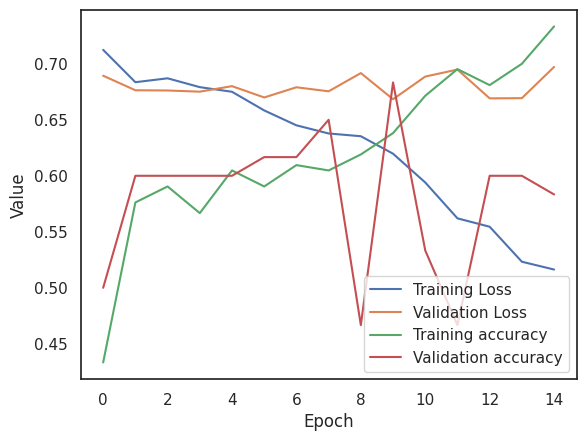

In [97]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model1 = LSTM_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model1.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

Epoch 1/200
7/7 [==============================] - 2s 79ms/step - loss: 0.7115 - accuracy: 0.5000 - val_loss: 0.6767 - val_accuracy: 0.6000
Epoch 2/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6714 - accuracy: 0.5381 - val_loss: 0.6880 - val_accuracy: 0.5667
Epoch 3/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6594 - accuracy: 0.6143 - val_loss: 0.7079 - val_accuracy: 0.4333
Epoch 4/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6481 - accuracy: 0.6333 - val_loss: 0.6934 - val_accuracy: 0.4667
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 0.6376 - accuracy: 0.6333 - val_loss: 0.6911 - val_accuracy: 0.4833
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.6252 - accuracy: 0.6810 - val_loss: 0.6822 - val_accuracy: 0.5667


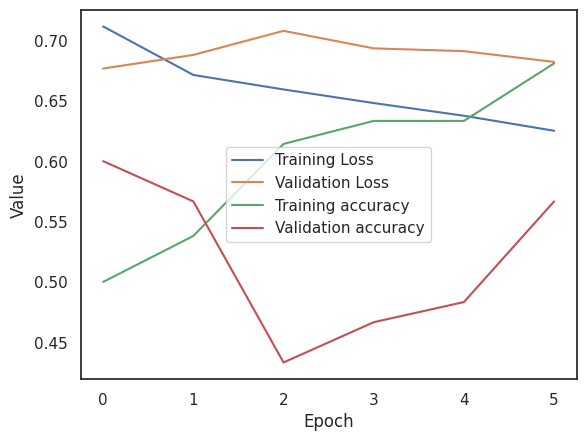

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model3 = Simple_LSTM_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model3.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

Epoch 1/200
7/7 [==============================] - 2s 36ms/step - loss: 0.7943 - accuracy: 0.4810 - val_loss: 0.8519 - val_accuracy: 0.5167
Epoch 2/200
7/7 [==============================] - 0s 8ms/step - loss: 0.7249 - accuracy: 0.5571 - val_loss: 0.8424 - val_accuracy: 0.5000
Epoch 3/200
7/7 [==============================] - 0s 8ms/step - loss: 0.6864 - accuracy: 0.5667 - val_loss: 0.7285 - val_accuracy: 0.5167
Epoch 4/200
7/7 [==============================] - 0s 8ms/step - loss: 0.6463 - accuracy: 0.6000 - val_loss: 0.7118 - val_accuracy: 0.5167
Epoch 5/200
7/7 [==============================] - 0s 8ms/step - loss: 0.6006 - accuracy: 0.6619 - val_loss: 0.7152 - val_accuracy: 0.5000
Epoch 6/200
7/7 [==============================] - 0s 8ms/step - loss: 0.6184 - accuracy: 0.6524 - val_loss: 0.7857 - val_accuracy: 0.5000
Epoch 7/200
7/7 [==============================] - 0s 8ms/step - loss: 0.5948 - accuracy: 0.7143 - val_loss: 0.7968 - val_accuracy: 0.5000
Epoch 8/200
7/7 [=========

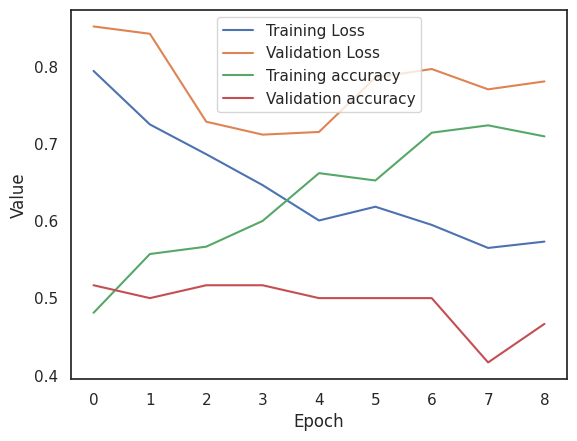

In [63]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model2 = CNN_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model2.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [28]:
# for NN
# X = data.drop(columns=["date","Target"])
# Y = np.array(data["Target"])

# sc = StandardScaler()
# sc.fit(data.drop(columns=["Target","date"]))
# X_sc = sc.transform(X)

# # Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
# enc = OneHotEncoder(sparse=False)

# # Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
# enc.fit(Y.reshape(-1, 1))

# # Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
# Y_enc = enc.transform(Y.reshape(-1, 1))

In [ ]:
print(X_sc.shape)

In [ ]:
# cutoff = 210
# x_train = X_sc[:cutoff]
# y_train = Y_enc[:cutoff]
# x_test = X_sc[cutoff:]
# y_test = Y_enc[cutoff:]

In [29]:

# early_stop = EarlyStopping(monitor='val_loss', patience=15)
# # Create model
# model4 = NN_model(x_train,y_train)
# # Train the model with 20 epochs and batch size of 32, using the early stopping callback
# history = model4.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# # Plot the training history for loss and accuracy
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.plot(history.history['accuracy'], label='Training accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

# Evaluation of LSTM model


In [148]:
y_pred = model1.predict(x_test, verbose=0)
y_pred = np.where(y_pred>0.4,0,1)
for i in range(10):
    print(y_pred[i],y_test[i])

[1 0] [1. 0.]
[1 0] [1. 0.]
[1 0] [0. 1.]
[1 0] [1. 0.]
[1 0] [0. 1.]
[1 0] [0. 1.]
[1 0] [0. 1.]
[1 0] [1. 0.]
[1 0] [0. 1.]
[1 0] [1. 0.]


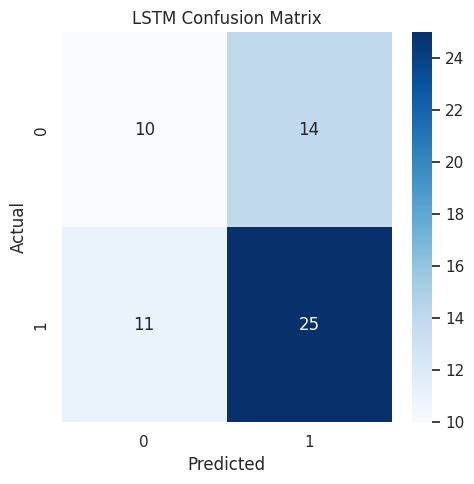

LSTM accuracy score: 0.5833333333333334


In [98]:
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(5, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

y_pred = enc.inverse_transform(model1.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'LSTM Confusion Matrix')
print("LSTM accuracy score:", accuracy_score(y_true, y_pred))

### classification report

In [99]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_true, y_pred))
print(f"AUC:{roc_auc_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           0       0.48      0.42      0.44        24
           1       0.64      0.69      0.67        36

    accuracy                           0.58        60
   macro avg       0.56      0.56      0.56        60
weighted avg       0.58      0.58      0.58        60

AUC:0.5555555555555556


### Featrure Importance

--------------- > Fold 1 < ---------------
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 37)]          0         
                                                                 
 bidirectional (Bidirection  (None, 10, 256)           169984    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 602       
                  

100%|██████████| 37/37 [00:02<00:00, 16.43it/s]


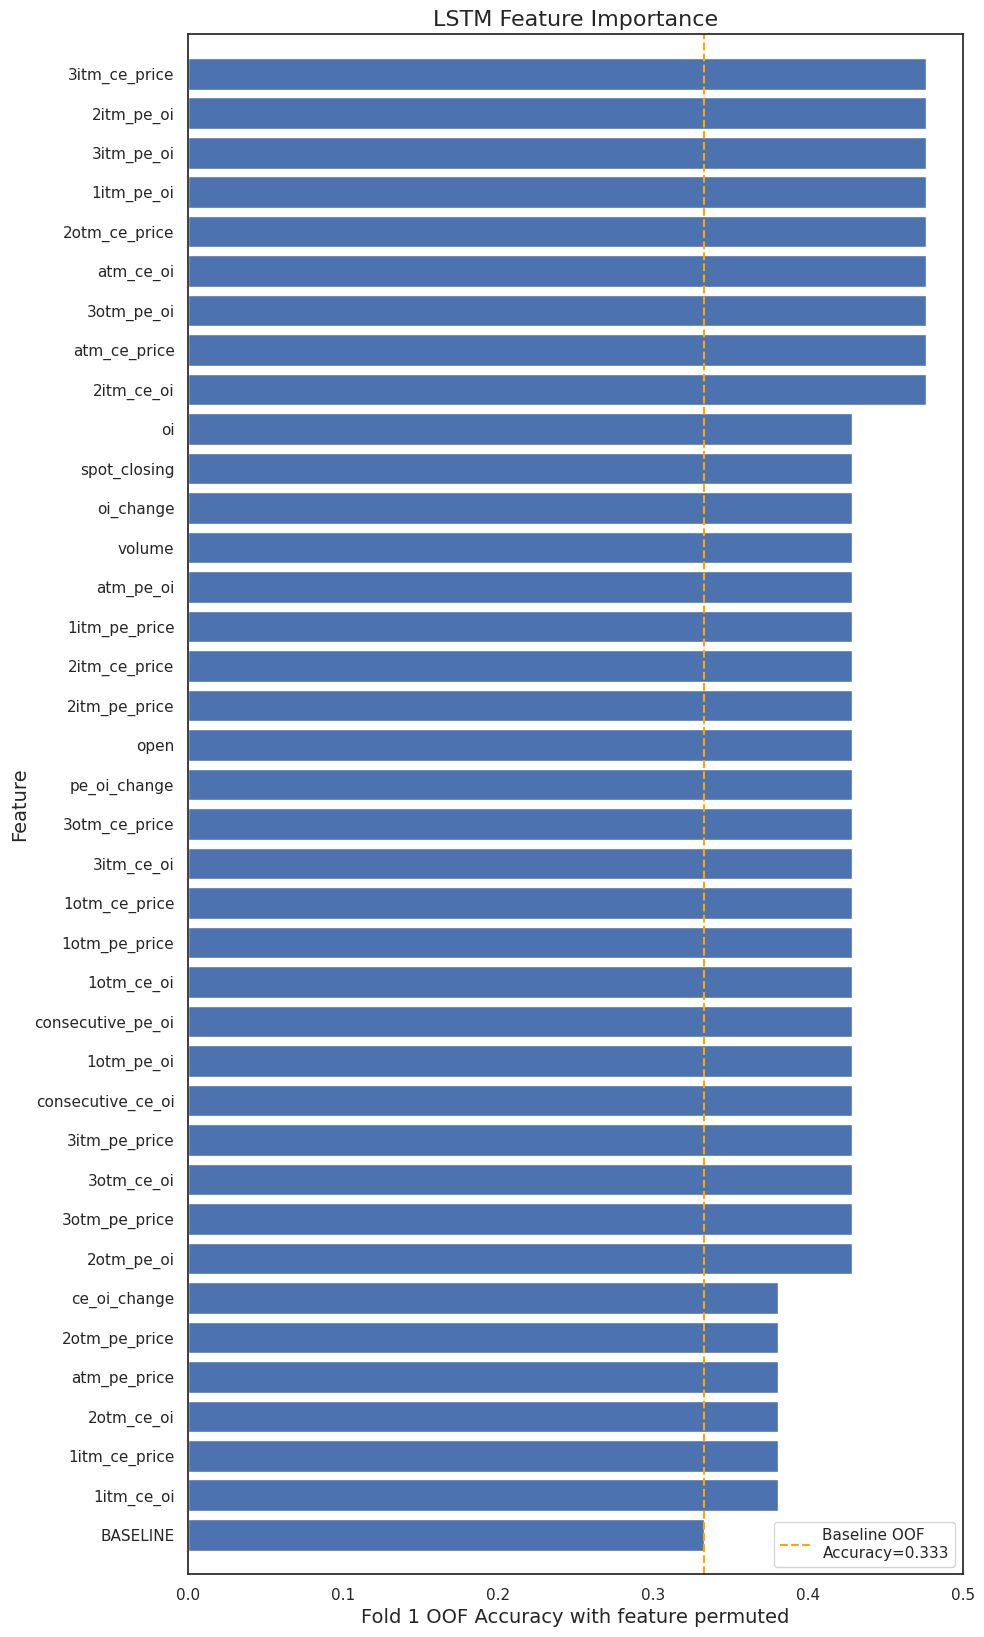

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

EPOCH = 300
BATCH_SIZE = 1024
NUM_FOLDS = 10

# Set this flag to True if you want to train the model, False if you want to load a pre-trained model
TRAIN_MODEL = True
# Set this flag to True if you want to infer on test data, False if you don't want to make predictions on test data
INFER_TEST = False
# Set this flag to True if you want to compute LSTM feature importance, False otherwise
COMPUTE_LSTM_IMPORTANCE = True
# Set this flag to True if you want to run the analysis on only one fold, False otherwise
ONE_FOLD_ONLY = True

# Assuming 'train' and 'targets' are your training data and labels, and 'test' is your test data
# COLS is the list of feature names

# Example data
train = x_train  # Replace with your actual data
targets = y_train  # Replace with your actual labels
test = x_test  # Replace with your actual test data
COLS = data.drop(columns=["Target","date"]).columns  # Replace with your actual feature names

# detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# GET GPU STRATEGY
gpu_strategy = tf.distribute.get_strategy()

with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2021)
    test_preds = []
    for fold, (train_idx, test_idx) in enumerate(kf.split(train, targets)):
        K.clear_session()

        print('-' * 15, '>', f'Fold {fold + 1}', '<', '-' * 15)
        X_train, X_valid = train[train_idx], train[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]

        checkpoint_filepath = f"folds{fold}.hdf5"
        if TRAIN_MODEL:
            model1 = LSTM_model(X_train, y_train)
            lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, verbose=1)
            es = EarlyStopping(monitor="val_loss", patience=60, verbose=1, mode="min", restore_best_weights=True)
            sv = tf.keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=False, mode='auto', save_freq='epoch',
                options=None
            )
            model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=EPOCH, batch_size=BATCH_SIZE,
                      callbacks=[lr, es, sv])

        else:
            model = tf.keras.models.load_model(checkpoint_filepath)

        if INFER_TEST:
            print(' Predicting test data...')
            test_preds.append(model.predict(test, verbose=0).squeeze().reshape(-1, 1).squeeze())

        if COMPUTE_LSTM_IMPORTANCE:
            results = []
            print(' Computing LSTM feature importance...')

            # COMPUTE BASELINE (NO SHUFFLE)
            oof_preds = model1.predict(X_valid, verbose=0).squeeze()
            baseline_acc = accuracy_score(y_valid, np.round(oof_preds))
            results.append({'feature': 'BASELINE', 'accuracy': baseline_acc})

            for k in tqdm(range(len(COLS))):
                # SHUFFLE FEATURE K
                save_col = X_valid[:, :, k].copy()
                np.random.shuffle(X_valid[:, :, k])

                # COMPUTE OOF ACCURACY WITH FEATURE K SHUFFLED
                oof_preds = model.predict(X_valid, verbose=0).squeeze()
                acc = accuracy_score(y_valid, np.round(oof_preds))
                results.append({'feature': COLS[k], 'accuracy': acc})
                X_valid[:, :, k] = save_col

            # DISPLAY LSTM FEATURE IMPORTANCE
            print()
            df = pd.DataFrame(results)
            df = df.sort_values('accuracy')
            plt.figure(figsize=(10, 20))
            plt.barh(np.arange(len(COLS) + 1), df.accuracy)
            plt.yticks(np.arange(len(COLS) + 1), df.feature.values)
            plt.title('LSTM Feature Importance', size=16)
            plt.ylim((-1, len(COLS) + 1))
            plt.plot([baseline_acc, baseline_acc], [-1, len(COLS) + 1], '--', color='orange',
                     label=f'Baseline OOF\nAccuracy={baseline_acc:.3f}')
            plt.xlabel(f'Fold {fold + 1} OOF Accuracy with feature permuted', size=14)
            plt.ylabel('Feature', size=14)
            plt.legend()
            plt.show()

            # SAVE LSTM FEATURE IMPORTANCE
            df = df.sort_values('accuracy', ascending=False)
            df.to_csv(f'lstm_feature_importance_fold_{fold + 1}.csv', index=False)

        # ONLY DO ONE FOLD
        if ONE_FOLD_ONLY:
            break


<Axes: >

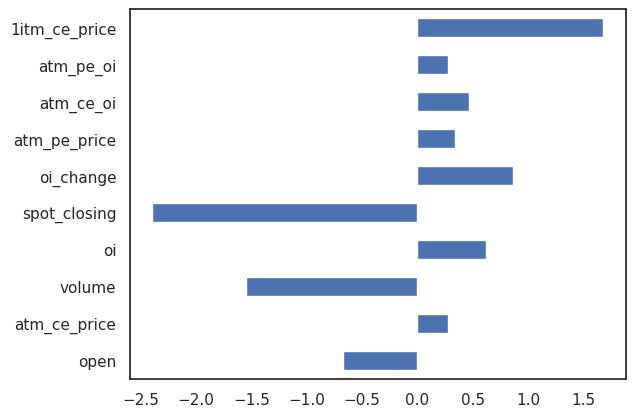

In [69]:
weights = model1.get_weights()
w = pd.DataFrame(weights[0],index=data.drop(columns=["Target","date"]).columns.to_list())
w['sum_all_columns'] = w.sum(axis=1)
w.head(10)["sum_all_columns"].plot(kind="barh")

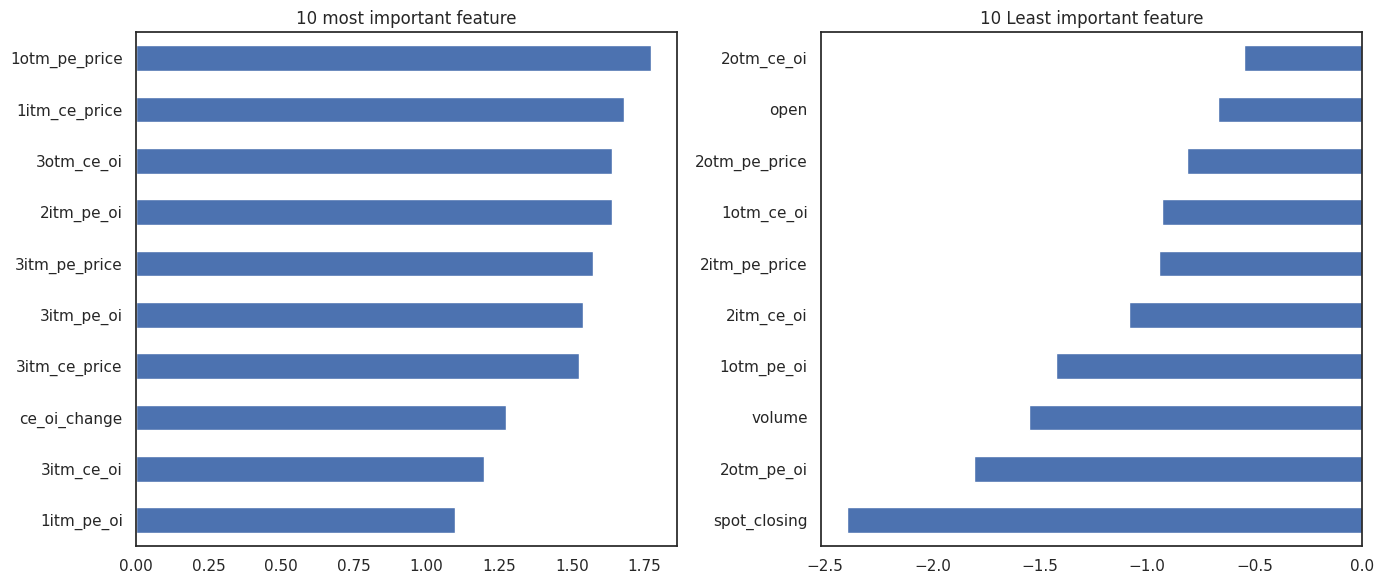

In [70]:
w_sorted = w.sort_values(by="sum_all_columns")

# Create subplots
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)

# Plot the top 10
w_sorted.tail(10)["sum_all_columns"].plot(kind="barh", ax=ax[0])
ax[0].set_title('10 most important feature')

# Plot the bottom 10
w_sorted.head(10)["sum_all_columns"].plot(kind="barh", ax=ax[1])
ax[1].set_title('10 Least important feature')

plt.tight_layout()
plt.show()

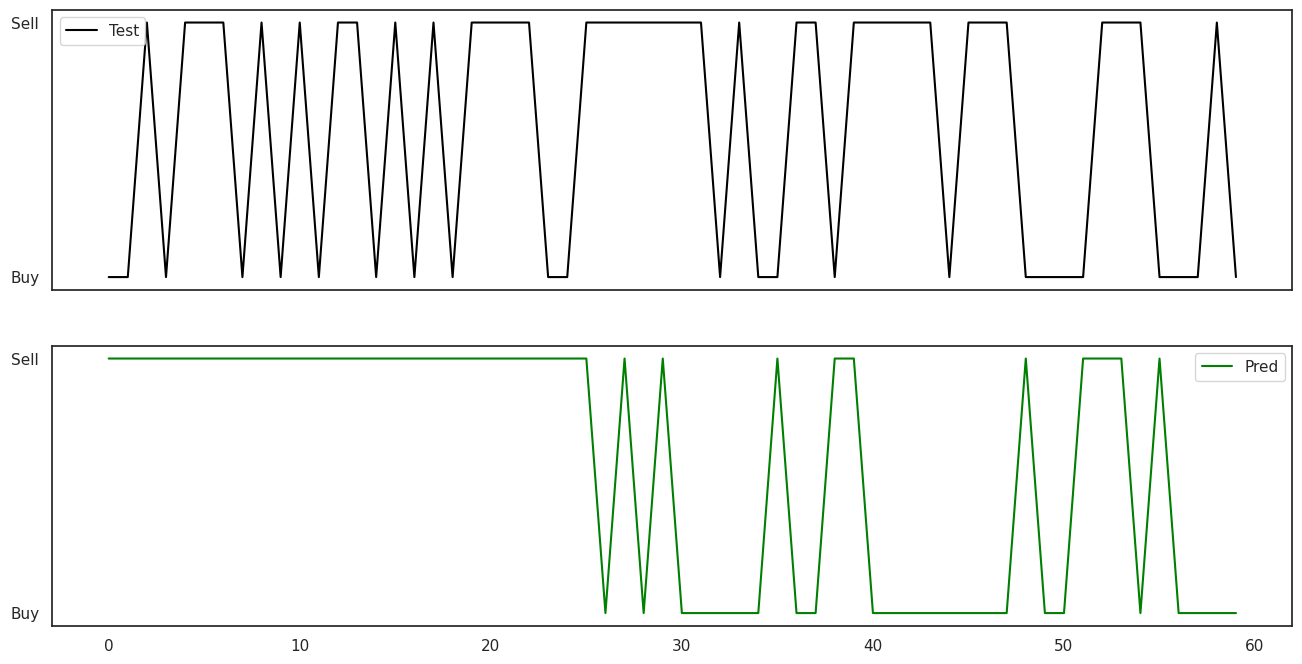

In [71]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

y_ticks = [0, 1]
y_labels = ['Buy', 'Sell']

# Plot the first subplot (top)
axs[0].plot(y_true, color='black', label='Test')
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].legend()

# Plot the second subplot (bottom)
axs[1].plot(y_pred, color='green', label='Pred')
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].legend()

# Show the plots
plt.show()

# Simple UNidiretional LSTM

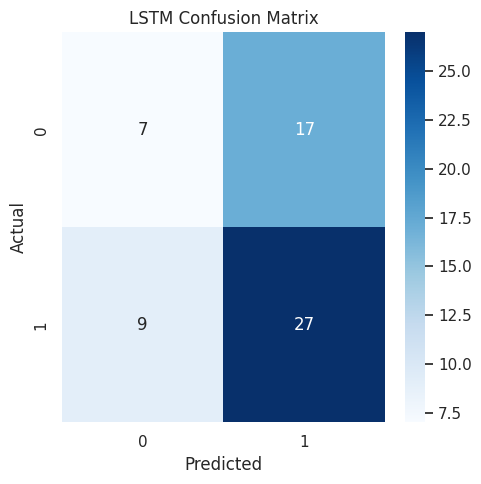

LSTM accuracy score: 0.5666666666666667


In [35]:
y_pred = enc.inverse_transform(model3.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'LSTM Confusion Matrix')
print("LSTM accuracy score:", accuracy_score(y_true, y_pred))

In [36]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_true, y_pred))
print(f"AUC:{roc_auc_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           0       0.44      0.29      0.35        24
           1       0.61      0.75      0.67        36

    accuracy                           0.57        60
   macro avg       0.53      0.52      0.51        60
weighted avg       0.54      0.57      0.54        60

AUC:0.5208333333333333


<Axes: >

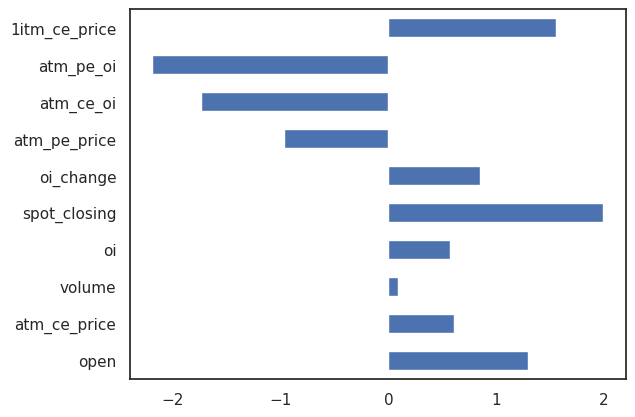

In [37]:
weights = model3.get_weights()
w = pd.DataFrame(weights[0],index=data.drop(columns=["Target","date"]).columns.to_list())
w['sum_all_columns'] = w.sum(axis=1)
w.head(10)["sum_all_columns"].plot(kind="barh")

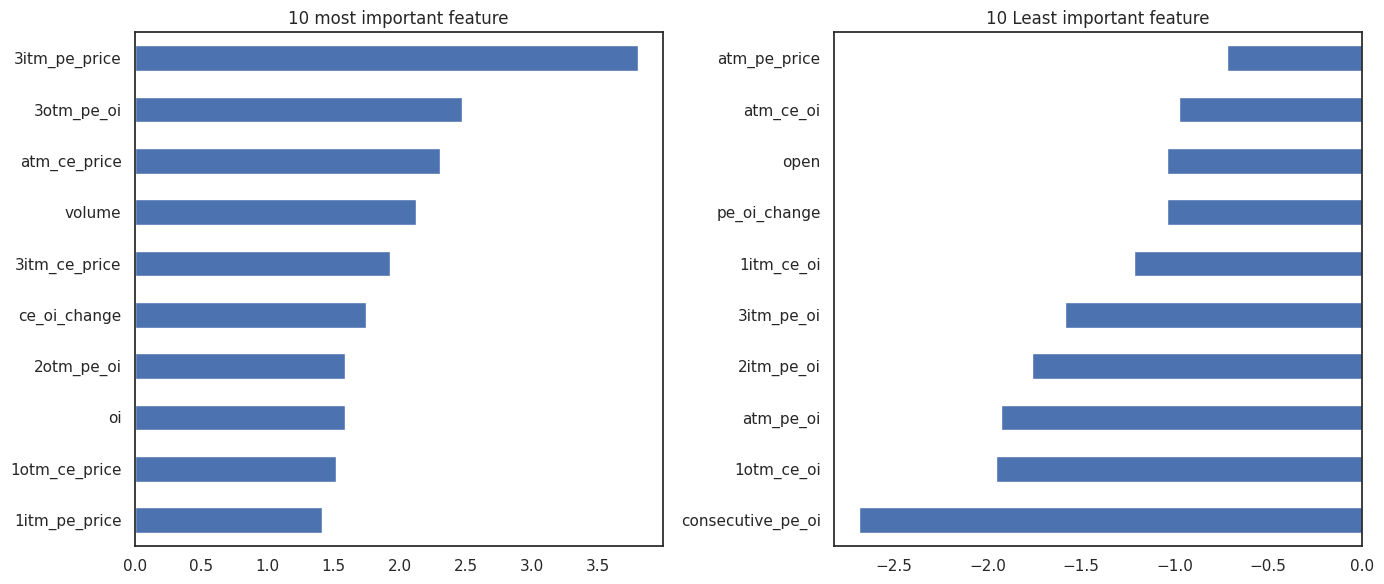

In [139]:
w_sorted = w.sort_values(by="sum_all_columns")

# Create subplots
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)

# Plot the top 10
w_sorted.tail(10)["sum_all_columns"].plot(kind="barh", ax=ax[0])
ax[0].set_title('10 most important feature')

# Plot the bottom 10
w_sorted.head(10)["sum_all_columns"].plot(kind="barh", ax=ax[1])
ax[1].set_title('10 Least important feature')

plt.tight_layout()
plt.show()

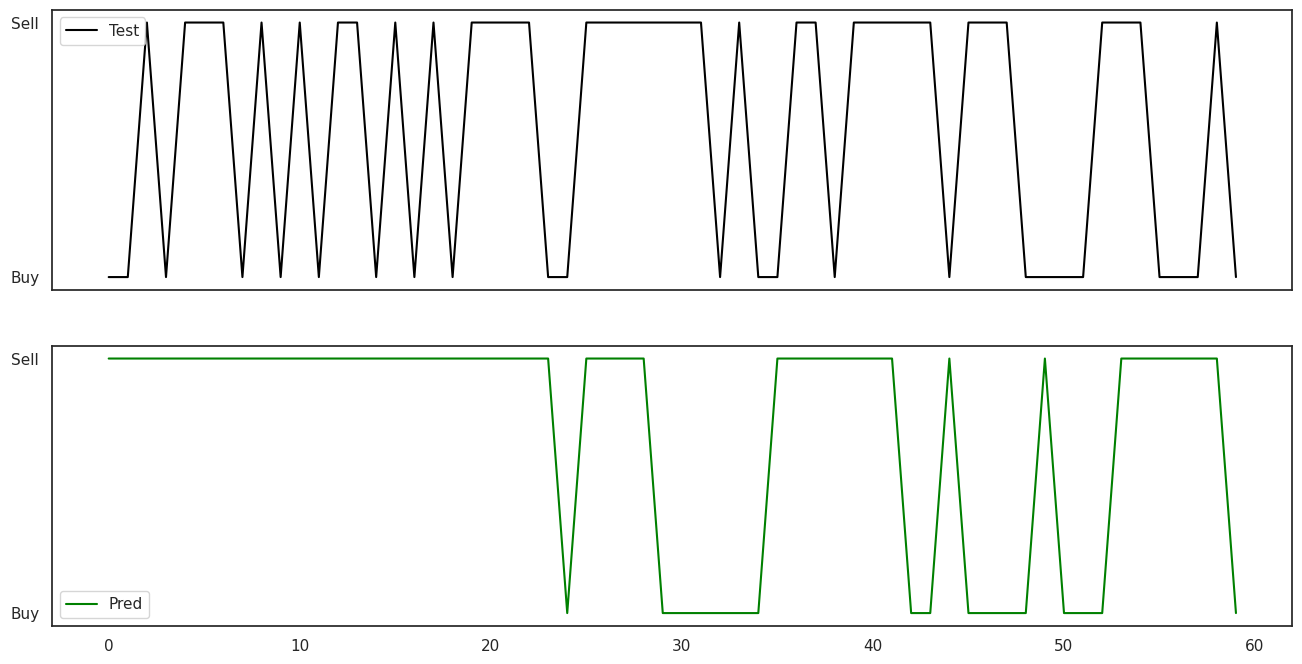

In [80]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

y_ticks = [0, 1]
y_labels = ['Buy', 'Sell']

# Plot the first subplot (top)
axs[0].plot(y_true, color='black', label='Test')
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].legend()

# Plot the second subplot (bottom)
axs[1].plot(y_pred, color='green', label='Pred')
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].legend()

# Show the plots
plt.show()

# CNN

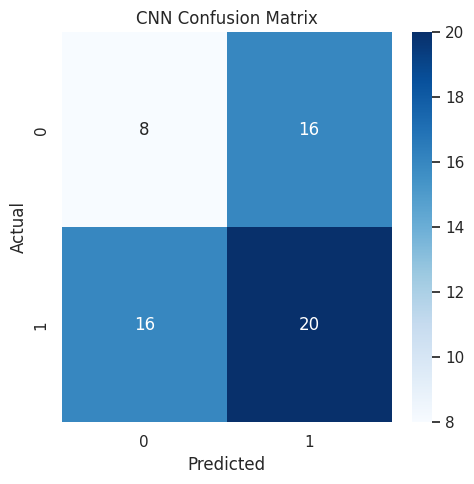

CNN accuracy score: 0.4666666666666667


In [64]:
y_pred = enc.inverse_transform(model2.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'CNN Confusion Matrix')
print("CNN accuracy score:", accuracy_score(y_true, y_pred))

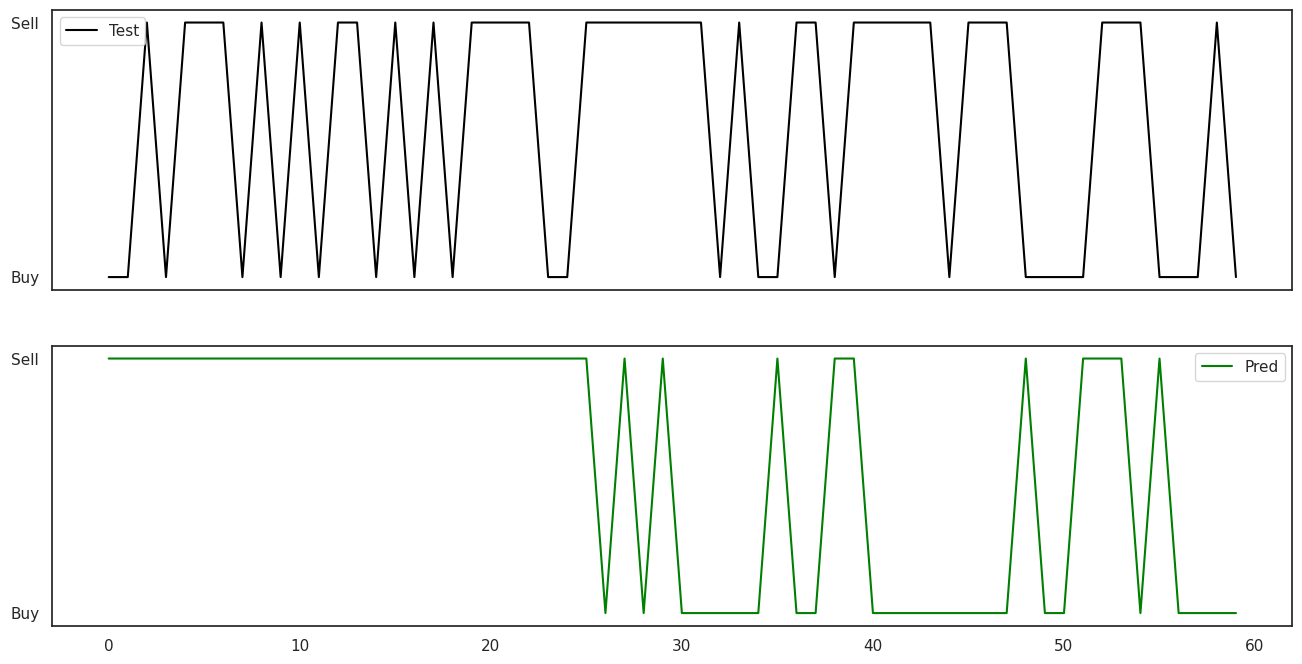

In [65]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

y_ticks = [0, 1]
y_labels = ['Buy', 'Sell']

# Plot the first subplot (top)
axs[0].plot(y_true, color='black', label='Test')
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].legend()

# Plot the second subplot (bottom)
axs[1].plot(y_pred, color='green', label='Pred')
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].legend()

# Show the plots
plt.show()

# BackTest

In [100]:
def backtest(y_pred, lot_size, nn=False):
    predicted =pd.DataFrame(y_pred,columns=["predicted"])
    if nn:
        cutoff = 250
    else:
        cutoff = 220
    predicted["date"] = data.date[cutoff:].to_list()
    predicted["Action"]=predicted["predicted"].apply(lambda x: "Sell" if x==1 else "Buy")
    predicted["price"] = feature_data[(feature_data.date > "2023-02-02 09:29:00") & (feature_data.date < "2023-02-02 14:10:00")].close[cutoff:].to_list()
    predicted["lot amount"] = predicted["price"] * 2.5 * lot_size
    predicted["new_pred"] = predicted["predicted"].apply(lambda x:(-1) if x == 0 else 1)
    predicted["diff"] = predicted["new_pred"] - predicted["new_pred"].shift(1)
    predicted.fillna(0,inplace=True)
    predicted["predicted1"] = predicted.apply(lambda row: 2 if row["diff"] != 0 else row["predicted"], axis=1)
    predicted.at[len(predicted)-1,"predicted1"] = 2
    t1 = predicted[predicted.predicted1 != 2][["date","Action","price","lot amount"]]
    t1.columns = ["Entry Time","Trade",'Entry Price',"Entry Amount"]
    t1["closed_position"] = "Yes"
    t2 = predicted[predicted.predicted1 == 2][["date","price","lot amount"]]
    t2.columns = ["Exit Time", "Exit Price","Exit Amount"]
    exit_time = []
    count = 0
    for i_1, d_1 in t2.iterrows():
        d1 = d_1["Exit Time"]
        for i_2,d_2 in t1[count:].iterrows():
            if d1 > d_2["Entry Time"]:
                exit_time.append(d1)
                count += 1
            else:
                break

    t1["Exit Time"] = exit_time
    backtest = pd.merge(t1,t2,'inner')
    backtest["profit/loss"] = np.where(backtest["Trade"] == "Buy",
                                       -1 * (backtest["Entry Amount"] - backtest["Exit Amount"]),
                                       backtest["Entry Amount"] - backtest["Exit Amount"])
    print(f"Total profit from this statergy is {backtest['profit/loss'].cumsum()[len(backtest)-1] - len(backtest) * 30}.")
    return backtest

In [101]:
import joblib
predicted =pd.DataFrame(y_pred,columns=["predicted"])
joblib.dump(predicted,"predicted.csv")

['predicted.csv']

In [102]:
CNN_y_pred = enc.inverse_transform(model2.predict(x_test, verbose=0))
CNN_backtest = backtest(CNN_y_pred, 1)

Total profit from this statergy is 6714.625.


In [103]:
LSTM_y_pred = enc.inverse_transform(model1.predict(x_test, verbose=0))
LSTM_backtest = backtest(LSTM_y_pred, 1)

Total profit from this statergy is 9040.5.


In [104]:
LSTM_backtest

,Entry Time,Trade,Entry Price,Entry Amount,closed_position,Exit Time,Exit Price,Exit Amount,profit/loss
0,2023-02-02 13:10:00,Sell,40563.15,101407.875,Yes,2023-02-02 13:38:00,40367.0,100917.50,490.375
1,2023-02-02 13:11:00,Sell,40556.45,101391.125,Yes,2023-02-02 13:38:00,40367.0,100917.50,473.625
2,2023-02-02 13:12:00,Sell,40565.00,101412.500,Yes,2023-02-02 13:38:00,40367.0,100917.50,495.000
3,2023-02-02 13:13:00,Sell,40555.60,101389.000,Yes,2023-02-02 13:38:00,40367.0,100917.50,471.500
4,2023-02-02 13:14:00,Sell,40548.95,101372.375,Yes,2023-02-02 13:38:00,40367.0,100917.50,454.875
5,2023-02-02 13:15:00,Sell,40526.85,101317.125,Yes,2023-02-02 13:38:00,40367.0,100917.50,399.625
6,2023-02-02 13:16:00,Sell,40561.20,101403.000,Yes,2023-02-02 13:38:00,40367.0,100917.50,485.500
7,2023-02-02 13:17:00,Sell,40538.75,101346.875,Yes,2023-02-02 13:38:00,40367.0,100917.50,429.375
8,2023-02-02 13:18:00,Sell,40540.50,101351.250,Yes,2023-02-02 13:38:00,40367.0,100917.50,433.750
9,2023-02-02 13:19:00,Sell,40539.80,101349.500,Yes,2023-02-02 13:38:00,40367.0,100917.50,432.000


In [105]:
LSTM_backtest.to_csv("LSTM_backtest_futures_data.csv")

In [106]:
LSTM_backtest[LSTM_backtest.Trade == "Buy"]['profit/loss'].cumsum()

28     125.750
29     382.500
30     535.625
31     541.500
32     572.625
33     629.250
34     521.000
35     450.375
36     408.750
39     573.000
40     746.625
41     945.000
42    1082.625
43    1097.000
44     962.000
45     779.875
46     614.000
Name: profit/loss, dtype: float64

In [107]:
LSTM_y_pred = enc.inverse_transform(model3.predict(x_test, verbose=0))
LSTM_backtest = backtest(LSTM_y_pred, 1)

Total profit from this statergy is 832.5.


# Prediction with options 

In [108]:
def backtest_with_options(y_pred, cutoff, itm,lot, data,df):
    predicted =pd.DataFrame(y_pred,columns=["predicted"])
    predicted["date"] = data.date[cutoff:].to_list()
    predicted["Action"]=predicted["predicted"].apply(lambda x: "Sell" if x==1 else "Buy")
    predicted["price"] = feature_data[(feature_data.date > "2023-02-02 09:29:00") & (feature_data.date < "2023-02-02 14:10:00")].close[cutoff:].to_list()
    predicted["new_pred"] = predicted["predicted"].apply(lambda x:(-1) if x == 0 else 1)
    predicted["diff"] = predicted["new_pred"] - predicted["new_pred"].shift(1)
    predicted.fillna(0,inplace=True)
    predicted["predicted1"] = predicted.apply(lambda row: 2 if row["diff"] != 0 else row["predicted"], axis=1)
    predicted.at[len(predicted)-1,"predicted1"] = 2
    predicted["trade_type"] = predicted["Action"].apply(lambda x: "PE" if x == "Sell" else "CE")
    spot_price = []
    strike_price = []
    otm = 3
    for i , data in predicted.iterrows():
        g = df[(df.strike == 0) & (df.date == data.date)].close.values[0]
        spot_price.append(g)
        if data["trade_type"] == "CE":
            g = g - 100 * itm
        else:
            g = g + 100 * itm
        strike_price.append(round(g/100)*100)
    predicted["otm_strike_price"] = strike_price
    predicted["spot_price"] = spot_price
    premium_price = []
    for ind, data in predicted.iterrows():
        g = df[(df.strike == data["otm_strike_price"]) & (df.date == data.date) & (df.type == data.trade_type)].close.values[0]
        premium_price.append(g)
    predicted["premium"] = premium_price
    t1 = predicted[predicted.predicted1 != 2][["date","trade_type","otm_strike_price","premium"]]
    t1.columns = ["Entry Time","Trade",'Strike Price',"premium price"]
    t1["closed_position"] = "Yes"
    t2 = predicted[predicted.predicted1 == 2][["date","trade_type"]]
    t2.columns = ["Exit Time", "Close Trade"]
    
    
    
    
    exit_time = []
    count = 0
    for i_1, d_1 in t2.iterrows():
        d1 = d_1["Exit Time"]
        for i_2,d_2 in t1[count:].iterrows():
            if d1 > d_2["Entry Time"]:
                exit_time.append(d1)
                count += 1
            else:
                break

    t1["Exit Time"] = exit_time
    backtest = pd.merge(t1,t2,'inner')
    backtest["Close Trade"] = backtest["Trade"]
    premium_price = []
    for ind, data in backtest.iterrows():
        g = df[(df.strike == data["Strike Price"]) & (df.date == data["Exit Time"]) & (df.type == data["Close Trade"])].close.values[0]
        premium_price.append(g)
    backtest["closed premium price"] = premium_price
    backtest["profit/loss"] = (backtest["closed premium price"] - backtest["premium price"]) * 50 * lot
    print(f"Total profit from this statergy is {backtest['profit/loss'].cumsum()[len(backtest)-1] - len(backtest) * 40}.")
    return backtest
    

In [109]:
LSTM_y_pred = enc.inverse_transform(model1.predict(x_test, verbose=0))
LSTM_backtest = backtest_with_options(LSTM_y_pred, 220, 1, 1, data,df)
LSTM_backtest.to_csv("LSTM_backtest_option.csv")

Total profit from this statergy is 148242.5.


In [110]:
LSTM_backtest

,Entry Time,Trade,Strike Price,premium price,closed_position,Exit Time,Close Trade,closed premium price,profit/loss
0,2023-02-02 13:10:00,PE,40400,174.10,Yes,2023-02-02 13:38:00,PE,304.50,6520.0
1,2023-02-02 13:11:00,PE,40400,179.50,Yes,2023-02-02 13:38:00,PE,304.50,6250.0
2,2023-02-02 13:12:00,PE,40400,170.00,Yes,2023-02-02 13:38:00,PE,304.50,6725.0
3,2023-02-02 13:13:00,PE,40400,179.00,Yes,2023-02-02 13:38:00,PE,304.50,6275.0
4,2023-02-02 13:14:00,PE,40400,185.60,Yes,2023-02-02 13:38:00,PE,304.50,5945.0
5,2023-02-02 13:15:00,PE,40400,192.05,Yes,2023-02-02 13:38:00,PE,304.50,5622.5
6,2023-02-02 13:16:00,PE,40400,174.55,Yes,2023-02-02 13:38:00,PE,304.50,6497.5
7,2023-02-02 13:17:00,PE,40400,187.95,Yes,2023-02-02 13:38:00,PE,304.50,5827.5
8,2023-02-02 13:18:00,PE,40400,187.85,Yes,2023-02-02 13:38:00,PE,304.50,5832.5
9,2023-02-02 13:19:00,PE,40400,184.15,Yes,2023-02-02 13:38:00,PE,304.50,6017.5


In [111]:
CNN_y_pred = enc.inverse_transform(model2.predict(x_test, verbose=0))
CNN_backtest = backtest_with_options(CNN_y_pred, 220, 1, 5,data,df)

Total profit from this statergy is 500090.0.


In [112]:
LSTM_y_pred = enc.inverse_transform(model3.predict(x_test, verbose=0))
LSTM_backtest = backtest_with_options(LSTM_y_pred, 220, 1, 5, data,df)

Total profit from this statergy is 125857.5.


## model2

In [114]:
model1.save("model_LSTM.pkl")
model2.save("model_CNN.pkl")